# Project 2
# Pairs Trading

### Axel Santiago Molina Ceja
### Pablo Lemus

## Overview

# **Pairs Trading Strategy Using MSFT and AMD**  

This project presents a **Pairs Trading Strategy** implemented in Python, focusing on the statistical arbitrage between **Microsoft (MSFT) and Advanced Micro Devices (AMD)**. The objective is to construct a robust trading model by identifying co-integrated assets, estimating the hedge ratio dynamically, and generating trading signals based on statistical thresholds.  

## **Project Overview**  

1. **Data Acquisition:** We collect **10 years of historical price data** for MSFT and AMD.  
2. **Co-Integration Analysis:** We verify that the assets maintain a stable economic relationship by testing for **stationarity and co-integration** through a Vector Error Correction Model (VECM).  
3. **Hedge Ratio Estimation:** The hedge ratio is dynamically updated using a **Kalman Filter**, implemented entirely from scratch (without external libraries).  
4. **Trading Strategy:** Signals are generated when the spread deviates **±1.5 standard deviations** from its mean, indicating potential trading opportunities.  
5. **Backtesting:** The strategy is backtested with an initial capital of **$1,000,000 USD**, accounting for **margin requirements** and **commissions of 0.125%** per trade.  

## **Economic Relationship Between MSFT and AMD**  

Microsoft and AMD share a strong economic relationship due to their involvement in the **technology and semiconductor industries**. AMD supplies processors and GPUs, many of which are used in Microsoft products such as **Azure cloud services, gaming consoles (Xbox), and enterprise computing solutions**. This supply-chain dependency and their exposure to common market factors (e.g., tech sector trends, macroeconomic conditions, and interest rates) create a **fundamental linkage** that supports their co-integration.  

By leveraging this economic relationship, the pairs trading strategy seeks to capitalize on temporary mispricings while maintaining a market-neutral position.

In [72]:
#!pip install yfinance

In [73]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [74]:
'''
def get_stock_prices(ticker):
    data = yf.download(ticker, period="10y")
    return data

msft = get_stock_prices("msft")
amd = get_stock_prices("amd")
msft.index
amd
#msft.to_csv("msft_stock_prices.csv")
#amd.to_csv("amd_stock_prices.csv")
'''


'\ndef get_stock_prices(ticker):\n    data = yf.download(ticker, period="10y")\n    return data\n\nmsft = get_stock_prices("msft")\namd = get_stock_prices("amd")\nmsft.index\namd\n#msft.to_csv("msft_stock_prices.csv")\n#amd.to_csv("amd_stock_prices.csv")\n'

In [75]:
msft = pd.read_csv('/Users/axelmolina/Desktop/Noveno Semestre/Trading/Pairs Trading/msft_stock_prices.csv').dropna()
amd = pd.read_csv('/Users/axelmolina/Desktop/Noveno Semestre/Trading/Pairs Trading/amd_stock_prices.csv').dropna()

amd.index
amd.head()
msft.head()

RangeIndex(start=0, stop=2515, step=1)

,Date,Close,High,Low,Open,Volume
0,20/02/15,3.06,3.13,3.02,3.03,10666700
1,23/02/15,3.06,3.10,3.03,3.05,6323500
2,24/02/15,3.11,3.12,3.02,3.06,10916300
3,25/02/15,3.10,3.14,3.06,3.08,6151300
4,26/02/15,3.08,3.13,3.06,3.10,8680900


,Date,Close,High,Low,Open,Volume
0,20/02/15,37.930290,37.947587,37.437352,37.627607,29721100
1,23/02/15,38.181103,38.215692,37.748701,37.791940,32518800
2,24/02/15,38.129204,38.310812,37.982185,38.181093,25271700
3,25/02/15,38.042725,38.129204,37.878410,38.008132,29759800
4,26/02/15,38.103260,38.250275,37.956242,38.042724,28957300


In [76]:
msft['Date'] = pd.to_datetime(msft['Date'])
msft.dtypes

/var/folders/0s/pfs98pjn34s7cc29x1xgw5c80000gn/T/ipykernel_89232/2886834163.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  msft['Date'] = pd.to_datetime(msft['Date'])


Date      datetime64[ns]
Close            float64
High             float64
Low              float64
Open             float64
Volume             int64
dtype: object

## Graph

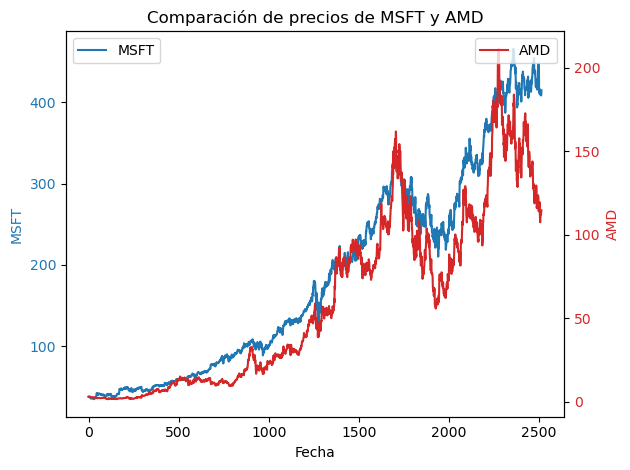

In [77]:
# Crear la figura y los ejes
fig, ax1 = plt.subplots()

# Graficar MSFT en el primer eje
ax1.set_xlabel('Fecha')
ax1.set_ylabel('MSFT', color='tab:blue')
ax1.plot(msft.index, msft['Close'], color='tab:blue', label='MSFT')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Crear un segundo eje para AMD
ax2 = ax1.twinx()
ax2.set_ylabel('AMD', color='tab:red')
ax2.plot(amd.index, amd['Close'], color='tab:red', label='AMD')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Añadir leyenda
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar el gráfico
plt.title('Comparación de precios de MSFT y AMD')
plt.tight_layout()  # Ajusta para que no se solapen los elementos
plt.show();

## Stationarity Check

In [78]:
msft_w_dates = msft
amd_w_dates = msft

In [79]:
msft = msft.Close
amd = amd.Close

In [80]:
def adf_test(series, ticker_name):
    result = adfuller(series)
    print(f"Resultados del ADF Test para {ticker_name}:")
    print(f"Estadístico ADF: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Conclusión:", "Estacionaria" if result[1] < 0.05 else "No estacionaria")
    print("-" * 50)

# Aplicar el test a cada serie
adf_test(msft, "MSFT")
adf_test(amd, "AMD")

Resultados del ADF Test para MSFT:
Estadístico ADF: 0.3488511096046325
p-value: 0.9794780249214788
Conclusión: No estacionaria
--------------------------------------------------
Resultados del ADF Test para AMD:
Estadístico ADF: -1.1225528767030875
p-value: 0.7059948006651972
Conclusión: No estacionaria
--------------------------------------------------


## OLS Regression and Cointegration check

In [81]:
# Alinear datos en el tiempo (por si alguna fecha falta en una de las series)
df = pd.concat([msft, amd], axis=1, keys=["MSFT", "AMD"]).dropna()

# Definir variables dependiente (Y) e independiente (X)
X = df["AMD"]  # Variable independiente
Y = df["MSFT"]   # Variable dependiente

# Agregar constante para la regresión
X = sm.add_constant(X)

# Ajustar modelo OLS
model = sm.OLS(Y, X).fit()

# Imprimir resumen de la regresión
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   MSFT   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                 5.068e+04
Date:                Sat, 22 Feb 2025   Prob (F-statistic):               0.00
Time:                        15:36:06   Log-Likelihood:                -11886.
No. Observations:                2515   AIC:                         2.378e+04
Df Residuals:                    2513   BIC:                         2.379e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         46.3753      0.829     55.969      0.0

In [82]:
residuals = model.resid

# Aplicar adf a residuales
adf_test(residuals, "Linear Relation")

Resultados del ADF Test para Linear Relation:
Estadístico ADF: -2.992907681140195
p-value: 0.03556206302623253
Conclusión: Estacionaria
--------------------------------------------------


## Eigenvectors

In [83]:
df = pd.concat([msft, amd], axis = 1)
df.columns = ["msft", "amd"]
df

,msft,amd
0,37.930290,3.060000
1,38.181103,3.060000
2,38.129204,3.110000
3,38.042725,3.100000
4,38.103260,3.080000
...,...,...
2510,409.040008,111.720001
2511,410.540008,111.809998
2512,408.429993,113.099998
2513,409.640015,114.279999


In [84]:
johansen_test = coint_johansen(df, det_order=0, k_ar_diff=1)

In [85]:
# 📌 4. Extraer y mostrar resultados clave
print("📊 **Resultados del Test de Cointegración de Johansen** 📊")

# Eigenvalues (Autovalores)
#print("\n🔹 **Eigenvalues (Autovalores):**")
#print(johansen_test.eig)

# Eigenvectors (Autovectores)
print("\n🔹 **Eigenvectors (Autovectores):**")
print(johansen_test.evec)
'''
# Trace Statistics
print("\n🔹 **Trace Statistics:**")
print(johansen_test.lr1)

# Eigenvalue Statistics
print("\n🔹 **Eigenvalue Statistics:**")
print(johansen_test.lr2)

# Valores críticos a diferentes niveles (90%, 95%, 99%)
print("\n🔹 **Valores Críticos (Trace Test):**")
print(johansen_test.cvt)

print("\n🔹 **Valores Críticos (Eigenvalue Test):**")
print(johansen_test.cvm)
'''

📊 **Resultados del Test de Cointegración de Johansen** 📊

🔹 **Eigenvectors (Autovectores):**
[[ 0.03451502 -0.01311565]
 [-0.08761341  0.01285124]]


'\n# Trace Statistics\nprint("\n🔹 **Trace Statistics:**")\nprint(johansen_test.lr1)\n\n# Eigenvalue Statistics\nprint("\n🔹 **Eigenvalue Statistics:**")\nprint(johansen_test.lr2)\n\n# Valores críticos a diferentes niveles (90%, 95%, 99%)\nprint("\n🔹 **Valores Críticos (Trace Test):**")\nprint(johansen_test.cvt)\n\nprint("\n🔹 **Valores Críticos (Eigenvalue Test):**")\nprint(johansen_test.cvm)\n'

## Spread Signals

In [86]:
u_t_list = []
for i in range (0,len(df)):
    u_t = johansen_test.evec[1,0]*df.amd[i] + johansen_test.evec[0,0]*df.msft[i]
    u_t_list.append(u_t)

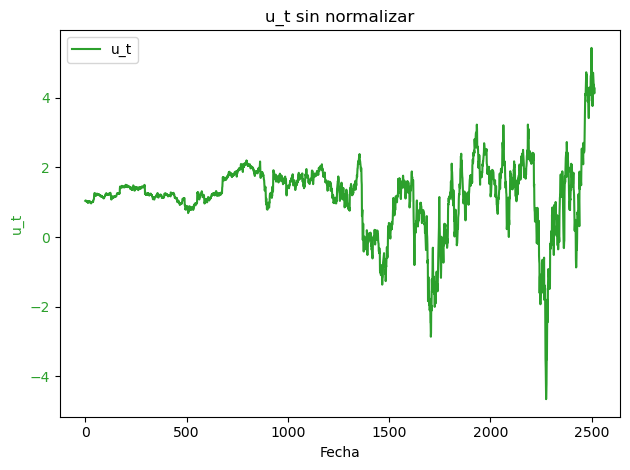

In [87]:
# Crear la figura y los ejes
fig, ax = plt.subplots()

msft_w_dates["u_t_list"]= u_t_list

# Graficar u_t_list con las fechas correspondientes
ax.set_xlabel('Fecha')
ax.set_ylabel('u_t', color='tab:green')
ax.plot(msft_w_dates.index, u_t_list, color='tab:green', label='u_t')
ax.tick_params(axis='y', labelcolor='tab:green')

# Añadir leyenda
ax.legend(loc='upper left')

# Mostrar el gráfico
plt.title('u_t sin normalizar')
plt.tight_layout()  # Ajusta para que no se solapen los elementos
plt.show();


## Normalized Spread Signals

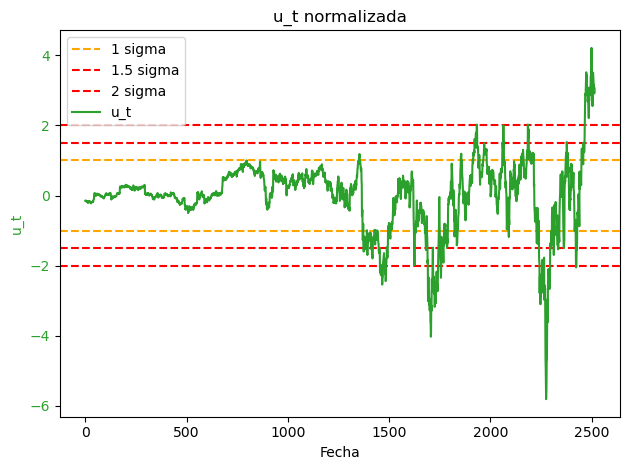

In [88]:
def normalize_z_score(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    normalized_data = [(x - mean) / std_dev for x in data]
    return normalized_data

normalized_u_t_list = normalize_z_score(u_t_list)

mean = np.mean(normalized_u_t_list)
std_dev = np.std(normalized_u_t_list)

# Definir los valores para 1 sigma, 1.25 sigma, y 2 sigma (positivos y negativos)
sigma_values = {
    '1 sigma': (mean - std_dev, mean + std_dev),
    '1.5 sigma': (mean - 1.5 * std_dev, mean + 1.5 * std_dev),
    '2 sigma': (mean - 2 * std_dev, mean + 2 * std_dev),
}

# Crear la figura y los ejes
fig, ax = plt.subplots()

for key, (lower, upper) in sigma_values.items():
    ax.axhline(y=lower, color='orange' if key == '1 sigma' else 'green' if key == '1.25 sigma' else 'red', linestyle='--', label=f'{key}')
    ax.axhline(y=upper, color='orange' if key == '1 sigma' else 'green' if key == '1.25 sigma' else 'red', linestyle='--')

# Graficar u_t_list con las fechas correspondientes
ax.set_xlabel('Fecha')
ax.set_ylabel('u_t', color='tab:green')
ax.plot(msft_w_dates.index, normalized_u_t_list, color='tab:green', label='u_t')
ax.tick_params(axis='y', labelcolor='tab:green')

# Añadir leyenda
ax.legend(loc='upper left')

# Mostrar el gráfico
plt.title('u_t normalizada')
plt.tight_layout()  # Ajusta para que no se solapen los elementos
plt.show();

## Kalman Filters

In [89]:
class KalmanFilterReg():
    def __init__(self):
        self.w = np.array([1, 1])
        self.A = np.eye(2) 
        self.Q = np.eye(2) *0.00000000000000000000001
        self.R = np.array([[1]]) # *100000
        self.P = np.eye(2)  

    def predict(self):
        self.P = self.A @ self.P @ self.A.T + self.Q

    def update(self, x, y):
        C = np.array([[1, x]]) # Observation matrix
        S = C @ self.P @ C.T + self.R
        K = self.P @ C.T @ np.linalg.inv(S) # Kalman Gain
        self.P = (np.eye(2) - K @ C) @ self.P # Update Error in covariance prediction
        self.w = self.w + K @ (y - C @ self.w) # Update estimations

    def params(self):
        return self.w[0], self.w[1] # Return b, m of the linear model

In [90]:
kalman_linear = KalmanFilterReg()
kalman_linear_preds = []
list_m = []
for i in range(len(df)):
    # Update P
    kalman_linear.predict()

    # Update w
    x = df.msft[i]
    y = df.amd[i]
    kalman_linear.update(x, y)
    
    # Use parameters to create estimations
    b,m = kalman_linear.params() # m is hedge ratio
    list_m.append(m)
    kalman_linear_preds.append(m*x+b)

In [91]:
b
m

-16.00832947730256

0.40671919368685644

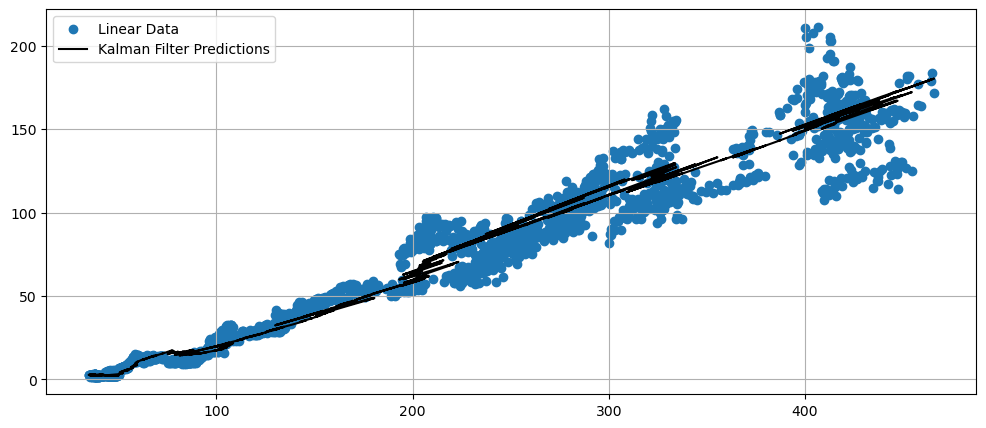

In [92]:
plt.figure(figsize=(12,5))
plt.scatter(msft, amd, label = "Linear Data")
plt.plot(msft, kalman_linear_preds, 'k', label = "Kalman Filter Predictions")
plt.grid()
plt.legend()
plt.show();
# Habrá un overfit

## Backtesting

In [93]:
df["Datetime"] = msft_w_dates.Date
df["Spread_Signal"] = normalized_u_t_list
df["m"] = list_m
df

,msft,amd,Datetime,Spread_Signal,m
0,37.930290,3.060000,2015-02-20,-0.151807,0.055623
1,38.181103,3.060000,2015-02-23,-0.143210,0.055108
2,38.129204,3.110000,2015-02-24,-0.149339,0.055403
3,38.042725,3.100000,2015-02-25,-0.151433,0.055515
4,38.103260,3.080000,2015-02-26,-0.147618,0.055460
...,...,...,...,...,...
2510,409.040008,111.720001,2025-12-02,3.114209,0.407573
2511,410.540008,111.809998,2025-02-13,3.157792,0.407350
2512,408.429993,113.099998,2025-02-14,2.973231,0.407142
2513,409.640015,114.279999,2025-02-18,2.912037,0.406938


In [94]:
capital = 1_000_000
com = 0.125 / 100
n_shares = 1800

active_positions = []
active_short_positions = []
portfolio_value = [capital]
Closeactual = 0

for i, row in df.iterrows():
    # update the kalman filter
    
    
    # Por arriba
    # Shortear
    if row.Spread_Signal > 1.5 and active_short_positions == []:
        Close = row.msft
        cost = Close * com * n_shares
        # Do we have enough cash?
        if (capital > cost) and (capital >250_000):
             # Spend money
             capital -= cost
             # Add position to portfolio
             active_short_positions.append({
                 "datetime": row.Datetime,
                 "bought_at": Close,
                 "shares": n_shares 
             })
    #Comprar
    if row.Spread_Signal > 1.5 and active_positions == []:
        Closebuy = row.amd
        # How expensive is the operation
        n_shares_adjusted = n_shares *row.m     # * 1.88     
        cost = (Closebuy*n_shares_adjusted) * (1+com) 
        # So we have enough cash?
        if (capital > cost) and (capital >250_000):
            # Spend Money
            capital -= cost
            # Add the position to a portfolio
            active_positions.append({
                "datetime": row.Datetime,
                "bought_at": Closebuy,
                "shares": n_shares
            })
    
        # Close Short positions
    if row.Spread_Signal < 0 and (df.Spread_Signal.shift(1).loc[row.name] > 0): 
        # Close all positions in the portfolio
        for position in active_short_positions:
            cost = row.msft * n_shares * com  #Comisión por comprar
            value = (position["bought_at"] - row.msft) * n_shares
            capital += (value - cost)
        active_short_positions = []

        # Close long positions
    if row.Spread_Signal < 0  and (df.Spread_Signal.shift(1).loc[row.name] > 0):
        # Close all positions in the portfolio
        for position in active_positions:
            Closeactual = row.amd
            value = Closeactual* n_shares_adjusted * (1-com)
            capital += value
        active_positions = []




    # Por abajo
        # Shortear
    if row.Spread_Signal  < -1.5 and active_short_positions == []:
        Close = row.amd 
        n_shares_adjusted = n_shares * row.m   #* 1.88    
        cost = Close * com * n_shares_adjusted
        # Do we have enough cash?
        if (capital > cost) and (capital >250_000):
             # Spend money
             capital -= cost
             # Add position to portfolio
             active_short_positions.append({
                 "datetime": row.Datetime,
                 "bought_at": Close,
                 "shares": n_shares #
             })

    #Comprar
    if row.Spread_Signal  < -1.5 and active_positions == []:
        Closebuy = row.msft
        # How expensive is the operation
        cost = (Closebuy*n_shares) * (1+com) 
        # So we have enough cash?
        if (capital > cost) and (capital >250_000):
            # Spend Money
            capital -= cost
            # Add the position to a portfolio
            active_positions.append({
                "datetime": row.Datetime,
                "bought_at": Close,
                "shares": n_shares
            })
    
        # Close Short positions
    if row.Spread_Signal  > 0  and (df.Spread_Signal.shift(1).loc[row.name] < 0): 
        # Close all positions in the portfolio
        for position in active_short_positions:
            cost = row.amd * n_shares_adjusted * com  #Comisión por comprar
            value = (position["bought_at"] - row.amd) * n_shares_adjusted
            capital += (value - cost)
        active_short_positions = []

        # Close long positions
    if row.Spread_Signal  > 0  and (df.Spread_Signal.shift(1).loc[row.name] < 0):
        # Close all positions in the portfolio
        for position in active_positions:
            Closeactual = row.msft
            value = (Closeactual  * n_shares) * (1-com)
            capital += value
        active_positions = []


    # Calculate portfolio value
    short_val = sum([(position["bought_at"]-Close) * n_shares for position in active_short_positions])
    num_long_pos = len(active_positions)
    long_pos_val = Close * num_long_pos * n_shares 
    #long_pos_val = Closeactual * num_long_pos * n_shares 
    portfolio_value.append(long_pos_val + short_val + capital)

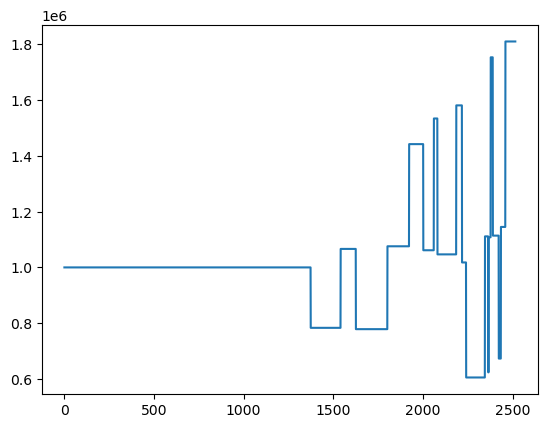

In [95]:
plt.plot(portfolio_value)